### Project Title:
## Explaining California Housing Prices Using Linear Regression

### 1. Problem Statement

#### Objective
Build an interpretable linear regression model to explain and predict median house values in California districts using census-derived numeric features.

#### Why Linear Regression
This project deliberately uses a single transparent model (Ordinary Least Squares) to:
- establish a strong baseline,
- produce interpretable coefficients,
- evaluate assumptions (linearity, residual behavior),
- communicate drivers of housing prices in business-friendly terms.

#### Dataset
Source: `sklearn.datasets.fetch_california_housing`

Target:
- `MedHouseVal` (median house value in units of $100,000)

Features:
- `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `Population`, `AveOccup`, `Latitude`, `Longitude`


### 2. Import libraries

In [13]:
# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Notebook display preferences
pd.set_option("display.max_columns", 200)
sns.set_theme()  # seaborn default theme

housing = fetch_california_housing(as_frame=True)

### 3. Load Data

We load the California Housing dataset from scikit-learn and convert it to a pandas DataFrame for analysis.

This dataset is well-suited for a linear regression baseline because:
- all predictors are numeric,
- no missing values are present (as provided by sklearn),
- features are interpretable and map to real-world factors.


In [14]:
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [16]:
# includes features + target 
# (use copy to safely clean, transform, and engineer features without altering the original dataset provided by scikit-learn.)
df = housing.frame.copy() 
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### 2. Quick Data Audit

We confirm:
- dataset shape,
- column names,
- basic descriptive statistics,
- missing values


This step prevents silent issues (e.g., unexpected nulls or strange ranges) from contaminating the modeling stage.


In [17]:
# Print the dimensionality of the dataset: (number of rows, number of columns)
print("Dataset shape:", df.shape)

Dataset shape: (20640, 9)


In [28]:
# Display a concise summary of the DataFrame:
# column names, non-null counts, and data types
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


None

In [60]:
# Generate descriptive statistics for numerical columns
# and transpose the result so each row corresponds to one feature
display(df.describe())

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


The dataset has no missing values and well-behaved location and age features, but several variables—such as rooms, occupancy, and population—contain extreme outliers that could affect linear regression assumptions and therefore require careful diagnostic analysis.

Extreme outliers can be identified directly from summary statistics by comparing maximum values to the upper quartile. In this dataset, several features such as average rooms, average bedrooms, population, and average occupancy exhibit maxima that are orders of magnitude larger than their 75th percentile values, indicating severe right-skew and the presence of extreme outliers.

In [30]:
# Compute the number of missing (NaN) values per column
# and sort columns from most missing to least
missing = df.isna().sum().sort_values(ascending=False)

# Print a header for clarity in the notebook output
print("\nMissing values per column:")

# Display only columns that actually contain missing values
display(missing[missing > 0])


Missing values per column:


Series([], dtype: int64)

### 3. Define Features and Target

We separate predictors (X) from the target (y).

Target:
- `MedHouseVal` (median house value, in units of $100,000)

We also create a train/test split to simulate out-of-sample performance.


In [19]:
# Define the name of the target (dependent) variable to be predicted
target_col = "MedHouseVal"

# Identify all remaining columns as feature (independent) variables by excluding the target column
feature_cols = [c for c in df.columns if c != target_col]

# Create the feature matrix X as a defensive copy to avoid mutating df
X = df[feature_cols].copy()

# Create the target vector y as a defensive copy
y = df[target_col].copy()

# Split the data into training and testing subsets
# - test_size=0.20 reserves 20% of the data for final model evaluation
# - random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Print the shapes of the training data to confirm the split
print("Train shape:", X_train.shape, y_train.shape)

# Print the shapes of the testing data to confirm the split
print("Test shape: ", X_test.shape, y_test.shape)

Train shape: (16512, 8) (16512,)
Test shape:  (4128, 8) (4128,)


### 4. EDA: Target Distribution

We inspect the target distribution to understand:
- skewness and tail behavior,
- whether extreme values exist,
- what error behavior we might expect.

Linear regression often struggles when the target has heavy tails or when the relationship is non-linear.


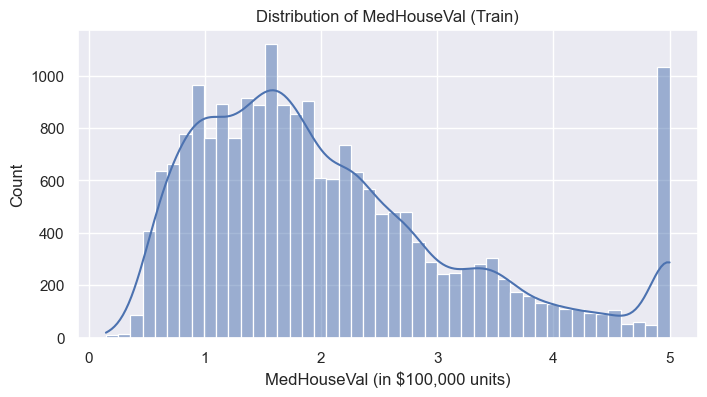

Target summary (train):


count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

In [81]:
plt.figure(figsize=(8, 4))
sns.histplot(y, kde=True)
plt.title("Distribution of MedHouseVal (Train)")
plt.xlabel("MedHouseVal (in $100,000 units)")
plt.ylabel("Count")
plt.show()

print("Target summary (train):")
display(y.describe())

The distribution of the target variable (MedHouseVal) shows a clear right-skew, with most observations concentrated between approximately 0.8 and 2.5. The mean value (2.07) exceeds the median (1.80), indicating that higher-priced homes pull the average upward. A pronounced spike at the maximum value of 5.0 reveals a ceiling effect *(a variable has a maximum value it cannot go above, even though the true values might actually be higher)* in the dataset, where house prices above $500,000 are capped. This censoring may limit the ability of linear regression to accurately model high-value properties and should be considered when interpreting model performance.

## 5. EDA: Feature Distributions

We visualize feature distributions to spot:
- heavy tails (often in population-related variables),
- scaling differences (motivating standardization),
- outliers that may influence OLS coefficients.


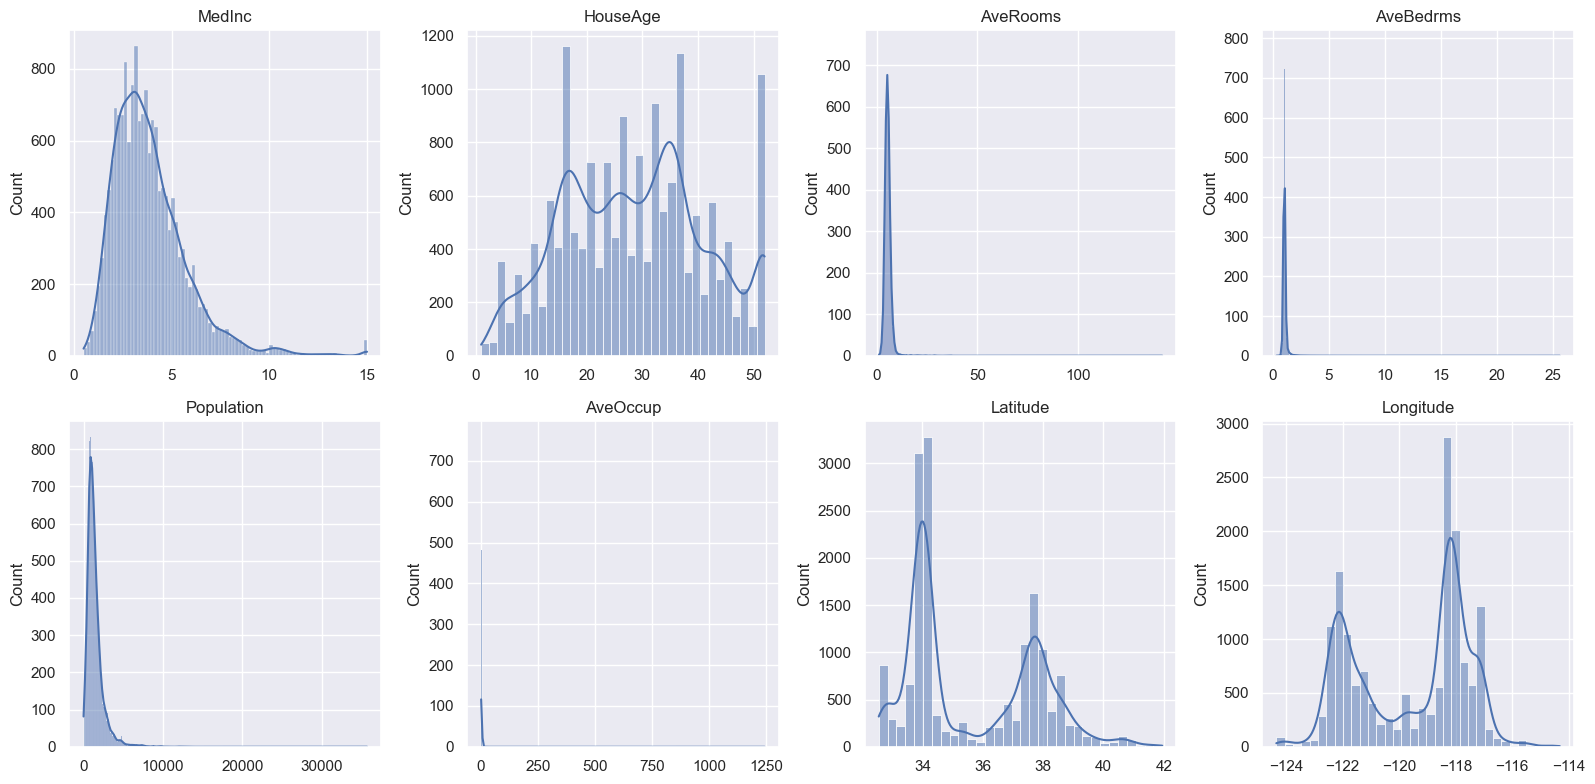

In [83]:
num_cols = feature_cols

# Plot a grid of histograms
n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))

plt.figure(figsize=(16, 4 * n_rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X_train[col], kde=True)
    plt.title(col)
    plt.xlabel("")
plt.tight_layout()
plt.show()

The feature distributions reveal substantial skewness and the presence of extreme values in several variables, particularly average rooms, bedrooms, population, and household occupancy. In contrast, housing age and geographic features exhibit more stable and interpretable distributions. These patterns suggest that while the dataset is rich and informative, careful preprocessing and diagnostic analysis are required to ensure linear regression assumptions are not severely violated.

### 6. EDA: Correlation Heatmap

Correlation helps identify:
- potential multicollinearity (highly correlated predictors),
- early signals of which features relate to the target.

Note: correlation does not imply causation; it is used here for diagnostic intuition.


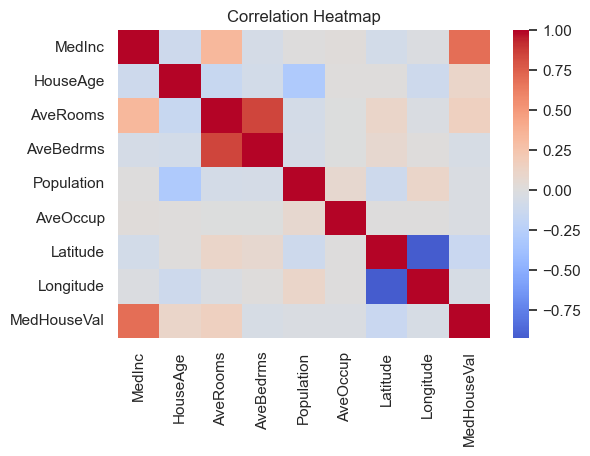

Correlation with target:


MedHouseVal    1.000000
MedInc         0.688075
AveRooms       0.151948
HouseAge       0.105623
AveOccup      -0.023737
Population    -0.024650
Longitude     -0.045967
AveBedrms     -0.046701
Latitude      -0.144160
Name: MedHouseVal, dtype: float64

In [79]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

# Target correlation (sorted)
target_corr = corr[target_col].sort_values(ascending=False)
print("Correlation with target:")
display(target_corr)


The correlation heatmap shows that median income exhibits the strongest positive relationship with median house value, confirming its role as the primary driver of housing prices. Average rooms and housing age display weaker positive correlations, while population and average occupancy contribute little linear signal. Geographic features show modest associations with house value, reflecting location effects. Strong correlation between average rooms and average bedrooms suggests potential multicollinearity (*happens when two or more input features are highly correlated with each other, meaning they contain almost the same information)*, which should be considered during model interpretation.

### 7. EDA: Key Relationships with Target

We create a small set of scatter plots for the most meaningful features to understand:
- whether relationships appear roughly linear,
- whether variance changes across the range (heteroscedasticity),
- whether geography (latitude/longitude) carries strong signal.

These plots inform expectations about where linear regression will underperform.


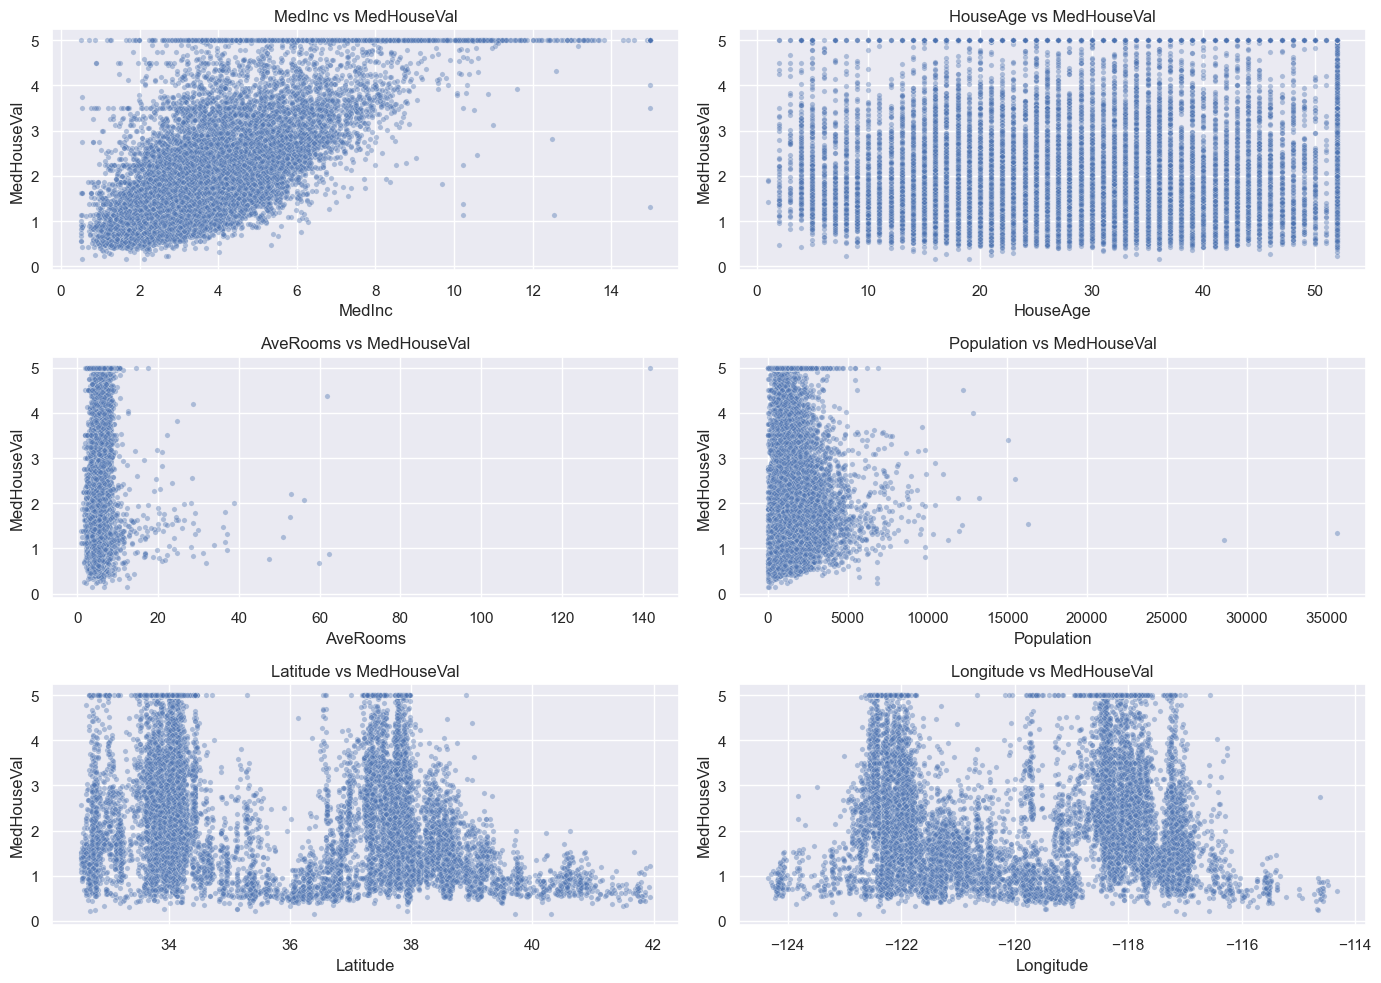

In [46]:
key_features = ["MedInc", "HouseAge", "AveRooms", "Population", "Latitude", "Longitude"]

plt.figure(figsize=(14, 10))
for i, col in enumerate(key_features, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x=X_train[col], y=y_train, s=15, alpha=0.4)
    plt.title(f"{col} vs MedHouseVal")
    plt.xlabel(col)
    plt.ylabel("MedHouseVal")
plt.tight_layout()
plt.show()


Scatter plots reveal that median income exhibits a strong positive relationship with median house value, making it the most informative predictor. Other variables, such as housing age and population, show weak or no clear linear relationship with the target. Geographic features display strong clustering, indicating spatial effects that influence house prices. Several predictors exhibit extreme outliers and non-linear patterns, and the presence of a ceiling effect at the maximum house value suggests limitations in modeling high-priced properties using linear regression.

### 8. Baseline Model (Predict the Mean)

A defensible ML workflow starts with a simple baseline.
For regression, predicting the mean target value provides a reference point.

If linear regression does not outperform this baseline meaningfully, the modeling approach needs to be reconsidered.


In [49]:
y_pred_baseline = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = mean_squared_error(y_test, y_pred_baseline)
r2_base = r2_score(y_test, y_pred_baseline)

print("Baseline (Predict Mean) Performance on Test:")
print(f"MAE : {mae_base:.4f}")
print(f"RMSE: {rmse_base:.4f}")
print(f"R2  : {r2_base:.4f}")


Baseline (Predict Mean) Performance on Test:
MAE : 0.9061
RMSE: 1.3107
R2  : -0.0002


A baseline model was constructed by predicting the mean house value from the training set for all test observations. This naïve approach resulted in an MAE of 0.91 and an RMSE of 1.31, corresponding to an average prediction error of approximately $91,000. The R² score was approximately zero, indicating that the model explains none of the variance in the target variable. This baseline establishes a minimum performance threshold that any trained regression model must exceed.

### 9. Linear Regression with a Preprocessing Pipeline

We use a `Pipeline` to ensure consistent preprocessing in training, cross-validation, and test evaluation.

Why StandardScaler here?
- OLS does not mathematically require scaling, but scaling improves:
  - numerical stability,
  - coefficient comparability across features,
  - consistency if we later extend to regularized linear models (Ridge/Lasso).


In [51]:
linreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LinearRegression())
])

linreg_pipeline


,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


### 10. Train and Evaluate on Hold-Out Test Set

We train on the training split and evaluate on the test split to estimate out-of-sample performance.

Primary metric:
- MAE (interpretable in target units)

Secondary metrics:
- RMSE (penalizes large errors)
- R² (variance explained)


In [53]:
linreg_pipeline.fit(X_train, y_train)

y_pred = linreg_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Performance on Test:")
print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2  : {r2:.4f}")


Linear Regression Performance on Test:
MAE : 0.5332
RMSE: 0.5559
R2  : 0.5758


Compared to the baseline model that predicts the mean house value for all observations, the linear regression model demonstrates substantial performance gains. The MAE decreases from 0.91 to 0.53, indicating a 41% reduction in average prediction error. Similarly, RMSE decreases from 1.31 to 0.56, reflecting fewer large errors. The R² score improves from approximately zero to 0.58, showing that the model explains over half of the variance in median house values. These results confirm that the linear regression model captures meaningful relationships in the data and significantly outperforms the no-skill baseline.

### 11. Cross-Validation (Robustness Check)

A single train/test split can be noisy.
Cross-validation provides a more stable estimate of expected performance.

We compute cross-validated MAE on the training set only to avoid contaminating the test set.


In [84]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = -cross_val_score(
    linreg_pipeline,
    X_train, y_train,
    scoring="neg_mean_absolute_error",
    cv=cv
)

cv_rmse = -cross_val_score(
    linreg_pipeline,
    X_train, y_train,
    scoring="neg_root_mean_squared_error",
    cv=cv
)

print("Cross-Validation Results (Train Only):")
print(f"MAE : mean={cv_mae.mean():.4f}, std={cv_mae.std():.4f}")
print(f"RMSE: mean={cv_rmse.mean():.4f}, std={cv_rmse.std():.4f}")


Cross-Validation Results (Train Only):
MAE : mean=0.5291, std=0.0094
RMSE: mean=0.7205, std=0.0139


Cross-validation confirms that the linear regression model is stable and generalizes well, with test-set performance closely matching training-fold estimates.

### 12. Coefficient Interpretation

After scaling, coefficients represent the expected change in the target (in $100,000 units)
for a one standard deviation increase in each feature, holding others constant.

This is one of the major advantages of linear regression:
- we can explain “drivers” rather than only produce predictions.


,feature,coefficient
0,MedInc,0.854383
3,AveBedrms,0.339259
1,HouseAge,0.122546
4,Population,-0.002308
5,AveOccup,-0.040829
2,AveRooms,-0.294410
7,Longitude,-0.869842
6,Latitude,-0.896929


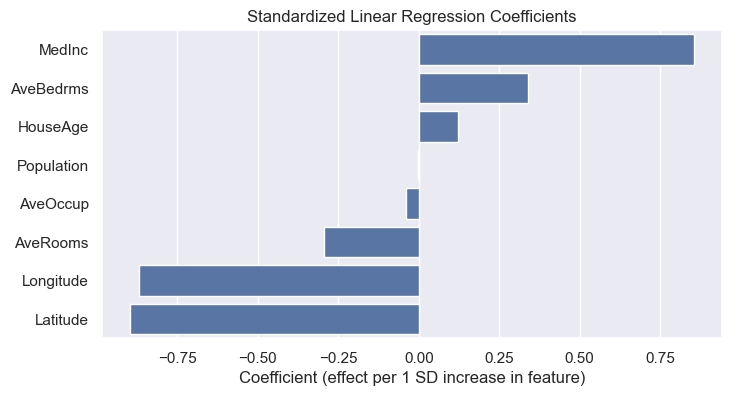

In [85]:
model = linreg_pipeline.named_steps["model"]
coefs = model.coef_

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coefs
}).sort_values("coefficient", ascending=False)

display(coef_df)

plt.figure(figsize=(8, 4))
sns.barplot(data=coef_df, x="coefficient", y="feature")
plt.title("Standardized Linear Regression Coefficients")
plt.xlabel("Coefficient (effect per 1 SD increase in feature)")
plt.ylabel("")
plt.show()


The standardized coefficient plot reveals that median income is the strongest positive predictor of median house value, confirming its dominant influence on housing prices. Geographic variables also exhibit large effects, reflecting regional price differences across California. Average bedrooms shows a moderate positive contribution, while average rooms displays a negative coefficient, likely due to multicollinearity between housing size variables. Population and average occupancy have coefficients near zero, indicating limited explanatory power once income and location are accounted for. Overall, the model relies primarily on socioeconomic and geographic factors to explain housing value variation.

### 13. Residual Diagnostics

Residual analysis helps validate linear regression assumptions and identify failure modes.

We examine:
- residuals vs predicted values (non-linearity, heteroscedasticity),
- residual distribution (skew, heavy tails),
- large-error cases (where the model performs poorly).


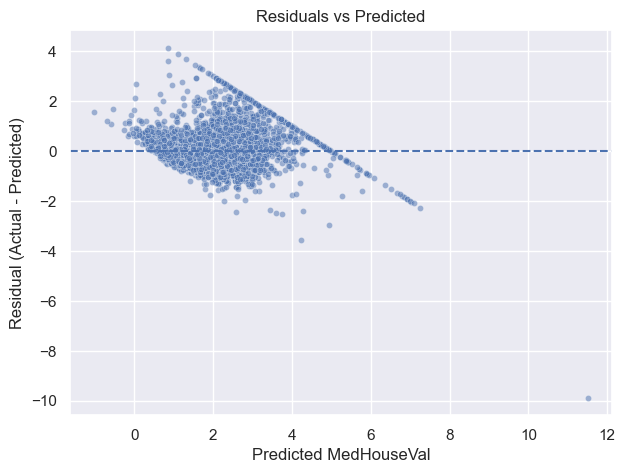

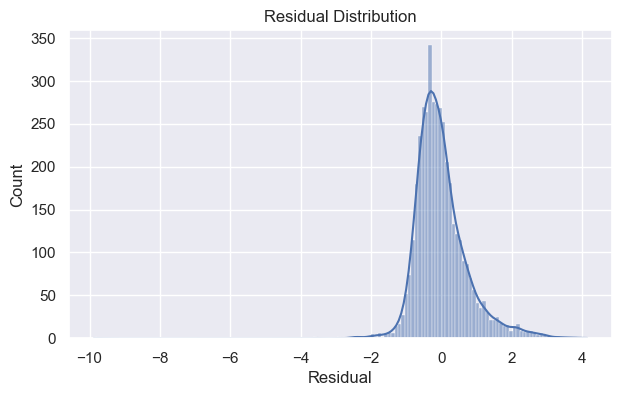

Residual summary:


count    4128.000000
mean        0.003479
std         0.745664
min        -9.875331
25%        -0.460935
50%        -0.122439
75%         0.312442
max         4.148388
Name: MedHouseVal, dtype: float64

In [56]:
residuals = y_test - y_pred

# Residuals vs predicted
plt.figure(figsize=(7, 5))
sns.scatterplot(x=y_pred, y=residuals, s=20, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted MedHouseVal")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

# Residual distribution
plt.figure(figsize=(7, 4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

print("Residual summary:")
display(pd.Series(residuals).describe())


The residuals versus predicted values plot reveals systematic patterns rather than random scatter. A clear downward trend indicates that the model tends to underpredict lower-priced homes and overpredict higher-priced homes. Additionally, the presence of a sharp diagonal boundary reflects a ceiling effect in the target variable, where house values are capped at 5.0. The increasing spread of residuals at lower predicted values suggests heteroscedasticity, indicating that the constant variance assumption of linear regression is violated. These patterns highlight inherent data limitations rather than model implementation errors.

### 14. Error Analysis: Largest Absolute Errors

A high-quality project does not stop at metrics.
We inspect the worst predictions to understand:
- where the model systematically fails,
- whether failures are associated with geography, high prices, or unusual districts.

This is often where you discover that the relationship is non-linear or that geographic effects dominate.


In [59]:
results = X_test.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred
results["abs_error"] = np.abs(results["y_true"] - results["y_pred"])
results["residual"] = results["y_true"] - results["y_pred"]

display(results.sort_values("abs_error", ascending=False).head(10))

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,y_true,y_pred,abs_error,residual
1979,4.6250,34.0,132.533333,34.066667,36.0,2.400000,38.80,-120.08,1.62500,11.500331,9.875331,-9.875331
6688,0.4999,28.0,7.677419,1.870968,142.0,4.580645,34.15,-118.08,5.00001,0.851622,4.148388,4.148388
10574,1.9659,6.0,4.795455,1.159091,125.0,2.840909,33.72,-117.70,5.00001,1.115227,3.884783,3.884783
12389,3.7727,24.0,10.953586,1.848101,473.0,1.995781,33.75,-116.43,5.00001,1.319954,3.680056,3.680056
19542,1.7679,39.0,5.000000,0.888889,22.0,2.444444,37.63,-120.92,4.50000,0.867216,3.632784,3.632784
4548,7.5752,52.0,3.142857,1.000000,55.0,7.857143,34.02,-118.21,0.67500,4.236215,3.561215,-3.561215
459,1.1696,52.0,2.436000,0.944000,1349.0,5.396000,37.87,-122.25,5.00001,1.547530,3.452480,3.452480
15652,0.9000,52.0,2.237474,1.053535,3260.0,2.237474,37.80,-122.41,5.00001,1.642870,3.357140,3.357140
12069,4.2386,6.0,7.723077,1.169231,228.0,3.507692,33.83,-117.55,5.00001,1.668034,3.331976,3.331976
4630,2.3674,20.0,2.740554,1.047859,2919.0,2.450882,34.07,-118.31,5.00001,1.711156,3.288854,3.288854


Inspection of individual predictions with the largest absolute errors reveals that extreme residuals are primarily driven by a ceiling effect in the target variable and by unusual feature values such as inflated average rooms, population, or occupancy. Several observations correspond to high-value areas where true prices are capped at 5.0, leading the model to systematically underpredict. In contrast, a small number of cases exhibit severe overprediction due to linear extrapolation in the presence of extreme ratios. These errors highlight inherent limitations of linear regression and the dataset rather than implementation issues.

### 16. Conclusions 

This project evaluated the use of a linear regression model to predict median house values in California using socioeconomic, housing, and geographic features. Exploratory data analysis revealed that the dataset is complete and informative but exhibits several challenging characteristics, including skewed feature distributions, extreme outliers, strong geographic clustering, and a ceiling effect in the target variable (`MedHouseVal`).

A baseline model that predicted the mean house value established a no-skill benchmark, yielding high error and an R² near zero. In contrast, the linear regression model demonstrated substantial improvement, reducing MAE by over 40% and explaining approximately 58% of the variance in house values. Cross-validation results closely matched test-set performance, indicating that the model generalizes well and does not suffer from overfitting.

Feature analysis showed that median income is the dominant predictor of house value, while geographic variables capture strong regional effects. Several housing density variables contributed little additional signal and exhibited multicollinearity. Residual diagnostics revealed heteroscedasticity and systematic bias at the upper end of predictions, largely driven by the artificial cap on house values and non-linear spatial effects.

Overall, the linear regression model performs well as an interpretable baseline and successfully captures major pricing drivers, but its limitations are clearly exposed by the structure of the data.


### 17. Recommendations

#### 1. Acknowledge data limitations explicitly

The ceiling effect at `MedHouseVal = 5.0` significantly constrains model performance for high-value properties. Any conclusions or predictions at the upper end of the price range should be interpreted with caution. This limitation should be clearly documented rather than treated as a modeling flaw.

#### 2. Improve stability with regularization

Strong correlations between features such as `AveRooms` and `AveBedrms` introduce multicollinearity, leading to unstable coefficient estimates. Ridge regression is recommended to improve coefficient stability while retaining interpretability.

#### 3. Apply targeted feature transformations

Highly skewed variables such as population, average rooms, and average occupancy distort linear relationships and residual variance. Applying transformations (e.g., logarithmic scaling or winsorization) could reduce the influence of extreme values and improve error consistency.

#### 4. Enhance spatial modeling

Latitude and longitude show strong but non-linear relationships with house values. Incorporating interaction terms, polynomial features, or spatial encodings could better capture regional price dynamics without abandoning linear modeling entirely.

#### 5. Consider non-linear models for performance gains

While linear regression provides transparency, tree-based models (e.g., Random Forests or Gradient Boosting) are better suited to handling non-linearities, outliers, and spatial effects. These models should be explored if predictive accuracy is prioritized over interpretability.

#### 6. Retain linear regression as a baseline

Despite its limitations, linear regression remains valuable as:

* A strong baseline model
* A diagnostic tool for understanding data behavior
* A reference point for evaluating more complex models

#### Final takeaway

The linear regression model successfully captures the primary drivers of housing prices—income and location—and significantly outperforms a naïve baseline. However, data constraints such as target censoring, skewed feature distributions, and non-linear geographic effects limit its ultimate accuracy. Future improvements should focus on regularization, feature transformation, and spatial modeling to address these challenges while balancing interpretability and performance.